In [1]:
import sklearn
from sklearn.datasets import load_digits

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2
from nn.nn import NeuralNetwork

In [3]:
X, y = load_digits(return_X_y=True)

In [4]:
X.shape

(1797, 64)

### Split into train and validation data

In [5]:
#doing a roughly 70/30 split
split_on = round(.7*X.shape[0])

#shuffle rows
np.random.seed(7)
row_idxs = np.arange(X.shape[0])
np.random.shuffle(row_idxs)
X_shuffled = X[row_idxs]

#split
X_train = X_shuffled[:split_on]
X_val = X_shuffled[split_on:]

X_train.shape, X_val.shape

((1258, 64), (539, 64))

In [73]:
#plotting function
def plot_loss(per_epoch_loss_train, per_epoch_loss_val):
    
    plt.plot(per_epoch_loss_train, label='training')
    plt.plot(per_epoch_loss_val, label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    
    plt.show()

### Make initial model (64x16x64)

I chose ReLu as my activation function for both layers because it partially behaves like a linear function and this problem is essentially linear regression. Also I haven't normalized the values in the dataset so I shouldn't use sigmoid or BCE unless I were to do that.

I chose MSE as the loss function because it's not a binary classification problem, it's linear.

In [100]:
model = NeuralNetwork(nn_arch =  [{'input_dim': 64, 'output_dim': 16, 'activation': 'relu'},
                                  {'input_dim': 16, 'output_dim': 64, 'activation': 'relu'}],
                          lr = 0.0001, seed = 7, batch_size = 100, 
                          epochs = 100, loss_function='mse')

per_epoch_loss_train, per_epoch_loss_val = model.fit(X_train, X_train, X_val, X_val)

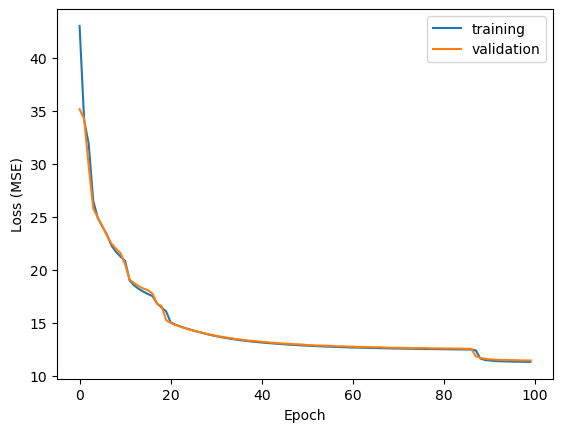

In [101]:
plot_loss(per_epoch_loss_train, per_epoch_loss_val)

### Tune hyperparameters

In [94]:
hyperparam_tune = []
for activation1 in ['sigmoid', 'relu']:
    for activation2 in ['sigmoid', 'relu']:
        for lr in [0.001, 0.0001, 0.00001]:
            for epoch in [10, 100, 1000]:
                for batch_size in [50, 250, 500]:

                    model = NeuralNetwork(nn_arch =  [{'input_dim': 64, 'output_dim': 16, 'activation': activation1},
                                          {'input_dim': 16, 'output_dim': 64, 'activation': activation2}],
                                  lr = lr, seed = 1, batch_size = batch_size, 
                                  epochs = epoch, loss_function='mse')

                    per_epoch_loss_train, per_epoch_loss_val = model.fit(X_train, X_train, X_val, X_val)

                    final_train_loss = min(per_epoch_loss_train)
                    final_val_loss = min(per_epoch_loss_val)

                    hyperparam_tune += [[activation1, activation2, lr, epoch, batch_size, final_train_loss, final_val_loss]]


In [102]:
df = pd.DataFrame(hyperparam_tune)
df.columns = ['activation1','activation2','LR', 'num_epochs', 'batch_size', 'train_MSE', 'val_MSE']

In [103]:
df.sort_values('val_MSE').head(5)

,activation1,activation2,LR,num_epochs,batch_size,train_MSE,val_MSE
96,relu,relu,0.0001,1000,50,6.332532,6.474270
33,sigmoid,relu,0.0010,1000,50,6.698263,7.190326
34,sigmoid,relu,0.0010,1000,250,7.869779,8.485898
97,relu,relu,0.0001,1000,250,9.172078,9.432515
98,relu,relu,0.0001,1000,500,9.248642,9.483405


### Best model (lowest validation error):

Found by playing with combinations of hyperparameters

In [105]:
epochs = 1000
batch_size = 50
lr = 0.0001
model = NeuralNetwork(nn_arch =  [{'input_dim': 64, 'output_dim': 16, 'activation': 'relu'},
                                  {'input_dim': 16, 'output_dim': 64, 'activation': 'relu'}],
                          lr = lr, seed = 1, batch_size = batch_size, 
                          epochs = epochs, loss_function='mse')

per_epoch_loss_train, per_epoch_loss_val = model.fit(X_train, X_train, X_val, X_val)
            

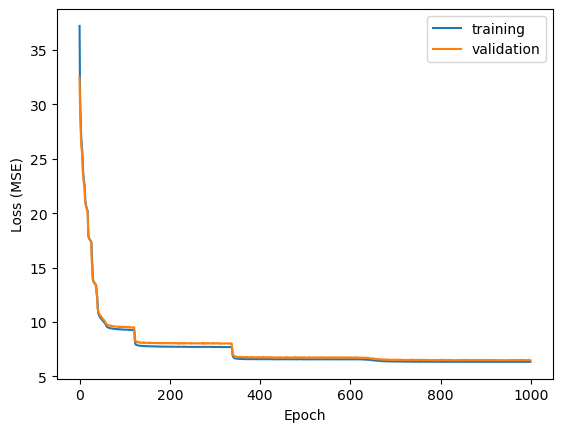

In [106]:
plot_loss(per_epoch_loss_train, per_epoch_loss_val)

**Reconstruction error is the MSE of the validation set:**

In [136]:
min(per_epoch_loss_val)

6.474270188031276

### Reconstruction examples

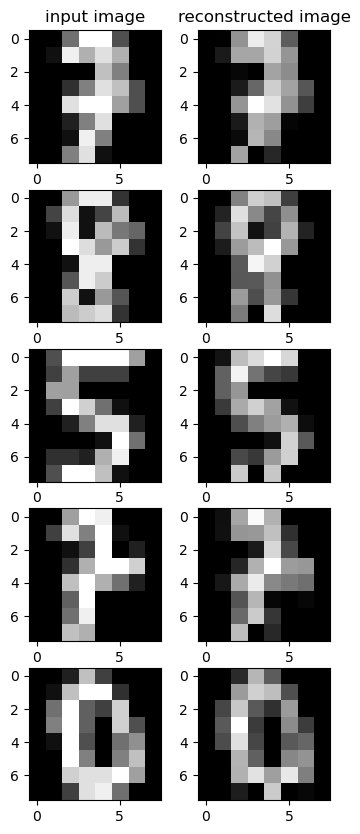

In [135]:
fig, ax = plt.subplots(5,2, figsize=(4,10))
ax[0,0].set_title('input image')
ax[0,1].set_title('reconstructed image')

for i,digit in enumerate(X_val[:5]):
    ax[i,0].imshow(digit.reshape((8,8)), cmap=pyplot.get_cmap('gray'))
    ax[i,1].imshow(model.predict(digit).reshape((8,8)), cmap=pyplot.get_cmap('gray'))

plt.show()